In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
import os
import seaborn as sns
import pickle

## My Params
rcParams["figure.dpi"] = 300 ## Higher resolution
rcParams["figure.constrained_layout.use"] = True ## Attempt constrained layout
rcParams['image.cmap'] = 'seismic' ## Change colormap
# rcParams['text.usetex'] = True ## Apply latex if needed


# -- Axes --
## Removing all axis except x-axis
rcParams['axes.spines.bottom'] = True
rcParams['axes.spines.left'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
## Adding Gridlines in the horizontally
rcParams['axes.grid'] = True
rcParams['axes.grid.axis'] = 'y'
rcParams['grid.color'] = 'grey'
rcParams['grid.linewidth'] = 0.5
## Some additional recommendations
rcParams['axes.axisbelow'] = True
rcParams['axes.linewidth'] = 2
rcParams['axes.ymargin'] = 0

# -- Ticks and tick labels --
rcParams['axes.edgecolor'] = 'grey'
rcParams['xtick.color'] = 'grey'
rcParams['ytick.color'] = 'grey'
rcParams['xtick.major.width'] = 2
rcParams['ytick.major.width'] = 0
rcParams['xtick.major.size'] = 5
rcParams['ytick.major.size'] = 0

# -- Fonts --
rcParams['font.size'] = 10
rcParams['font.family'] = 'serif'
rcParams['text.color'] = 'grey'
rcParams['axes.labelcolor'] = 'grey'

# -- Figure size --
rcParams['figure.figsize'] = (7, 4)

# -- Saving Options --
rcParams['savefig.bbox'] = 'tight'
rcParams['savefig.dpi'] = 500
rcParams['savefig.transparent'] = True

# -- Plot Styles --
rcParams['lines.linewidth'] = 3
navy = (56 / 256, 74 / 256, 143 / 256)
teal = (106 / 256, 197 / 256, 179 / 256)
pink = [199 / 255, 99 / 255, 150 / 255]
from cycler import cycler
rcParams['axes.prop_cycle'] = cycler(color=[teal, navy, pink])

# -- Scatter Plots --
rcParams["scatter.marker"] = "."

# Things to add in plots
## clip_on=False
## Title position a bit higher, y=1.03


# Function Definitions

In [2]:
def cutoff_index(arr,cutoff):
    max_cutoff = len(arr)
    if np.all(np.invert(np.isfinite(arr))):
        return np.nan
    arr = arr[np.isfinite(arr)]
    for i in range(len(arr)):
        if np.all(arr[i:]>cutoff):
            return i
    return max_cutoff-1

def compute_threshold_array(KL_df,cutoff,p):
    m_list = np.sort(np.unique(KL_df.m.values))[::-1] ## Flipping the m_list to start from larger to smaller
    n_list = np.sort(np.unique(KL_df.n.values))
    m_threshold_list = [] ## a list of size equal to n_list, where each entry is the m threshold for a corresponding n
    n_threshold_list = [] ## a list of size equal to m_list, where each entry is the n threshold for a corresponding m

    for n in n_list:
        temp_arr = KL_df[KL_df.n == n].sort_values("m").loc[:,"p_%d"%p].values[::-1]
        m_threshold_list.append(m_list[cutoff_index(temp_arr,cutoff)])

    for m in m_list:
        temp_arr = KL_df[KL_df.m == m].sort_values("n").loc[:,"p_%d"%p].values
        n_threshold_list.append(n_list[cutoff_index(temp_arr,cutoff)])

    return m_threshold_list,n_threshold_list

## Loading Files

In [3]:
path = "../data/eigen_analysis/cont/"
folders = os.listdir(path)
m_folders = np.array(os.listdir(path+folders[0]))
N_list = []
m_list = []

for i,folder in enumerate(folders):
    N = float(folder.split("=")[2])
    N_list.append(N)
folders = np.array(folders)

for i,folder in enumerate(m_folders):
    m = float(folder.split("=")[1])
    m_list.append(m)
folders = np.array(folders)
m_list = np.array(m_list)

m_order = np.argsort(m_list)
m_ordered = np.sort(m_list)

n_list = np.linspace(2,51,50).astype(int)
L_list = np.geomspace(500,8000,20).astype(int)

### Combining data from different folders into a single dataframe

In [4]:
with open(path+folders[2]+"/"+m_folders[0]+"/eigenvalues.pkl","rb") as file:
    test_eigenvalues = pickle.load(file)

column_names =["N","m"]+list(test_eigenvalues.columns)
full_df = pd.DataFrame(columns = column_names)
for N in N_list:
    for i,folder in enumerate(m_folders[m_order]):
        try:
            with open(path+"K=3,N=%d/"%N+folder+"/eigenvalues.pkl","rb") as file:
                temp_df = pickle.load(file)
            m = m_ordered[i]
            temp_df['m'] = [m]*len(temp_df.index) ## Adding columns to the eigenvalue df of a specific m and K
            temp_df['N'] = [N]*len(temp_df.index)
            temp_df = temp_df[["N","m"]+list(temp_df.columns[:-2])] # Rearranging the columns
            full_df = pd.concat([full_df,temp_df])
        except: 
            continue
full_df.replace(np.inf,10,inplace=True) ## very small p-values will have a -log10(p) set to 10

full_df.N = full_df.N.astype(int)
full_df.n = full_df.n.astype(int)
full_df.L= full_df.L.astype(int)


full_df["nL"] = full_df.n * full_df.L
full_df["-log(m)"] = -np.log10(full_df.m)
with open("../data/full_data/cont.pkl","wb") as file:
    pickle.dump(full_df,file)

## Eigenvalue Analysis

In [5]:
with open("../data/full_data/cont.pkl","rb") as file:
    full_df = pickle.load(file)

### Phase Transition Behaviour

In [43]:
N=2000
eigenvalue_index = 4
L = L_list[-2]
N_df = full_df[full_df.N == N]
NL_df = N_df[N_df.L == L]
NL_df = NL_df.sample(frac=1).reset_index(drop=True)


#### Eigenvalues & p-values vs sigma

Text(0.5, 0.01, 'sigma')

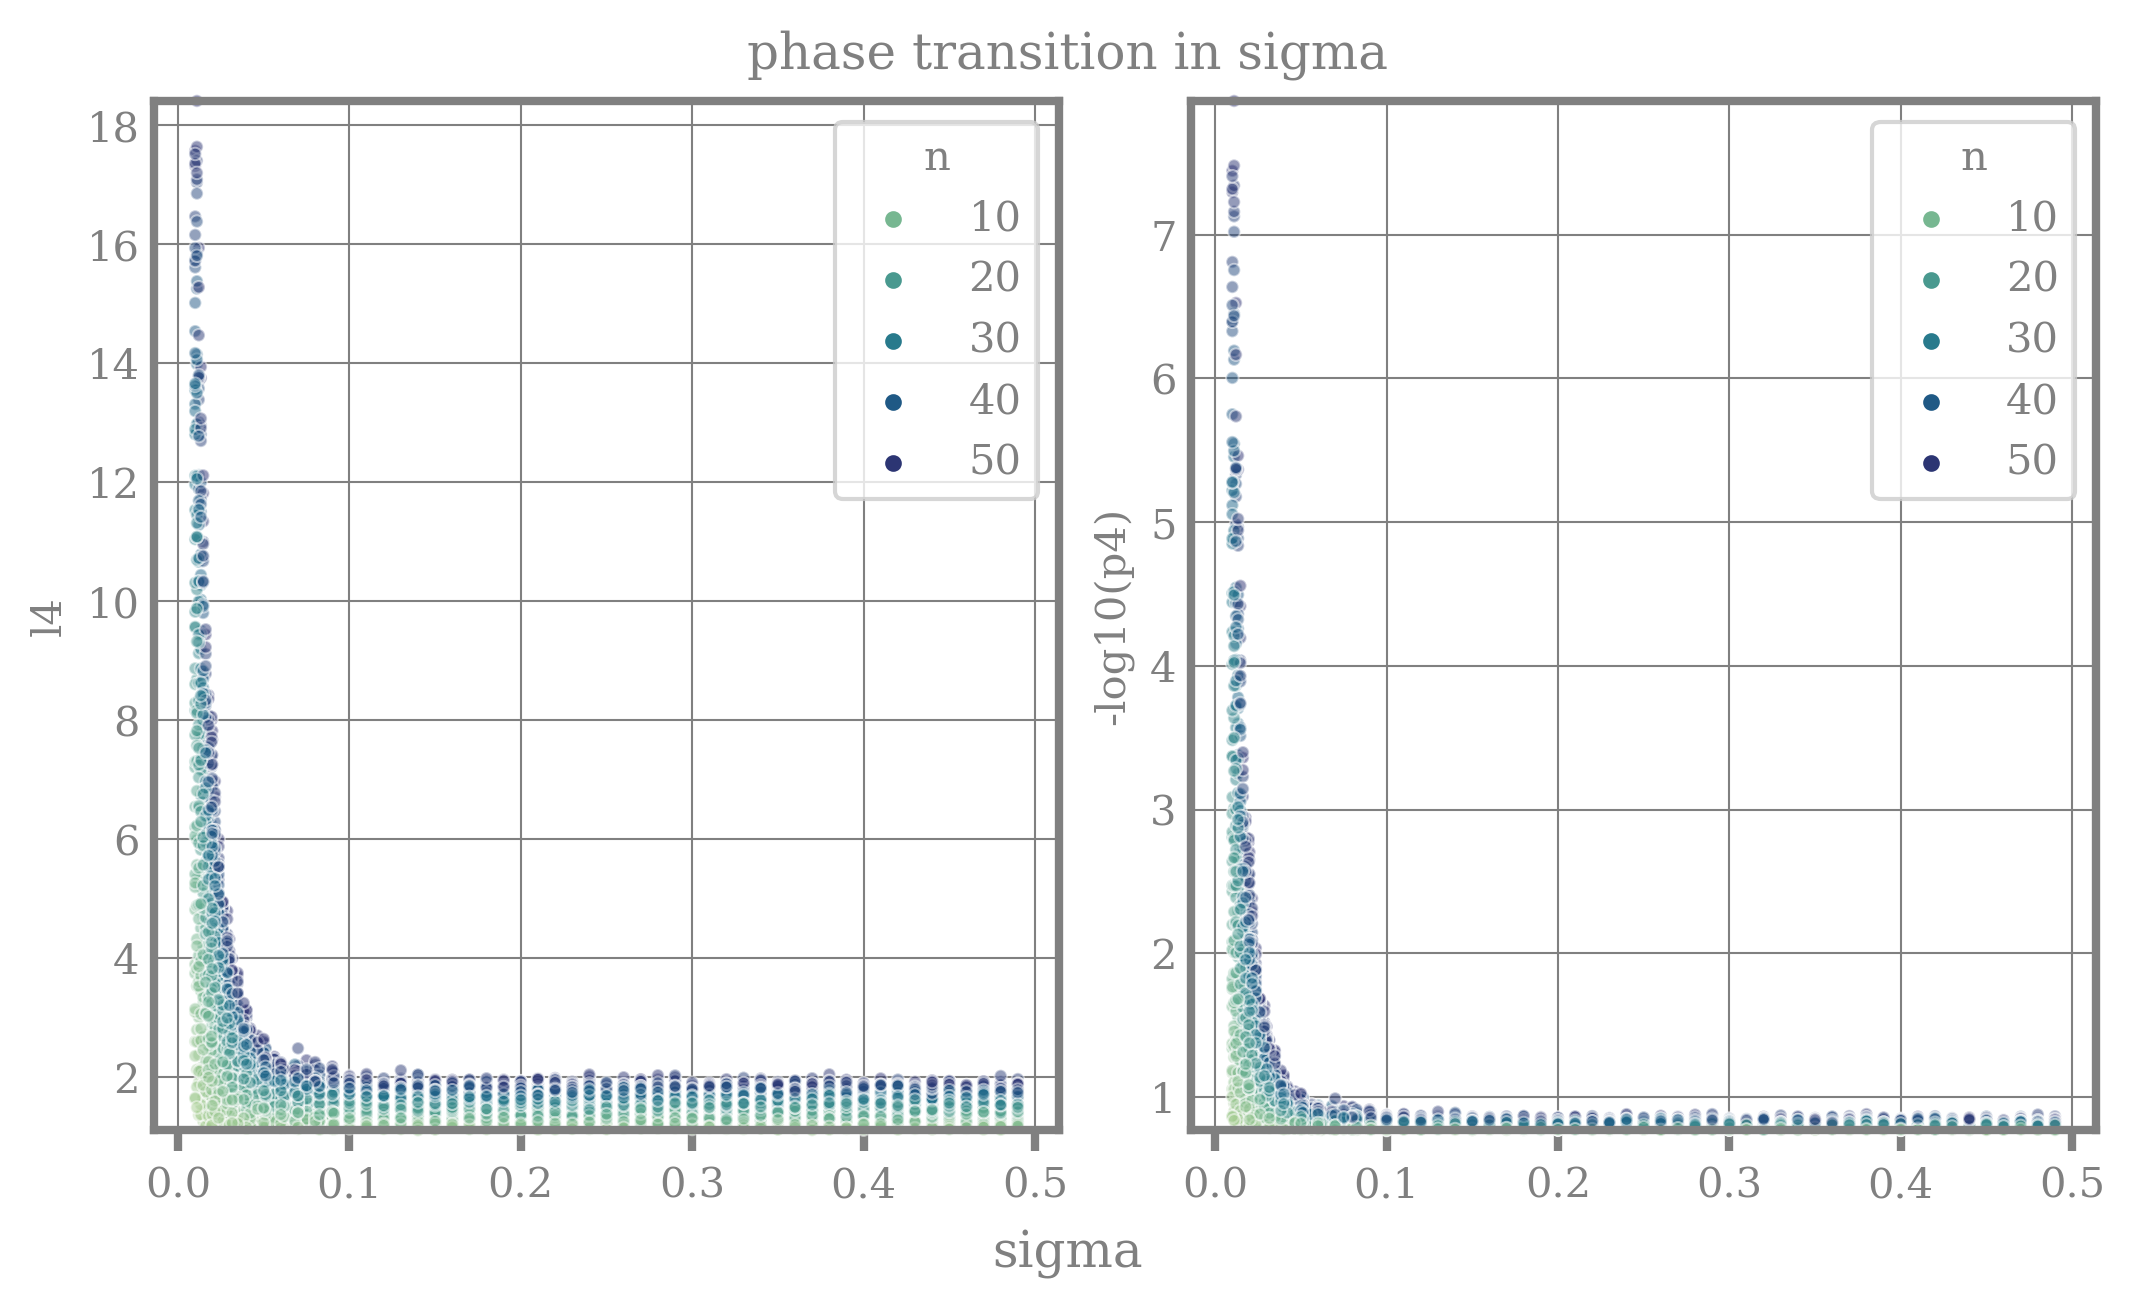

In [44]:
fig,axs = plt.subplots(1,2)
sns.scatterplot(NL_df,x = 'm',y='l_%d'%eigenvalue_index,hue='n',palette = 'crest',ax=axs[0],clip_on=False,alpha=0.5)
axs[0].set_xlabel("m")
axs[0].set_ylabel("l%d"%eigenvalue_index)
axs[0].set_xlabel("")

sns.scatterplot(NL_df,x = 'm',y='p_%d'%eigenvalue_index,hue='n',palette = 'crest',ax=axs[1],clip_on=False,alpha=0.5)
axs[1].set_ylabel("-log10(p%d)"%eigenvalue_index)
axs[1].set_xlabel("")


fig.suptitle("phase transition in sigma",y=1.05)
fig.supxlabel("sigma")

#### Eigenvalues & p-values vs -log10(sigma)

TypeError: not all arguments converted during string formatting

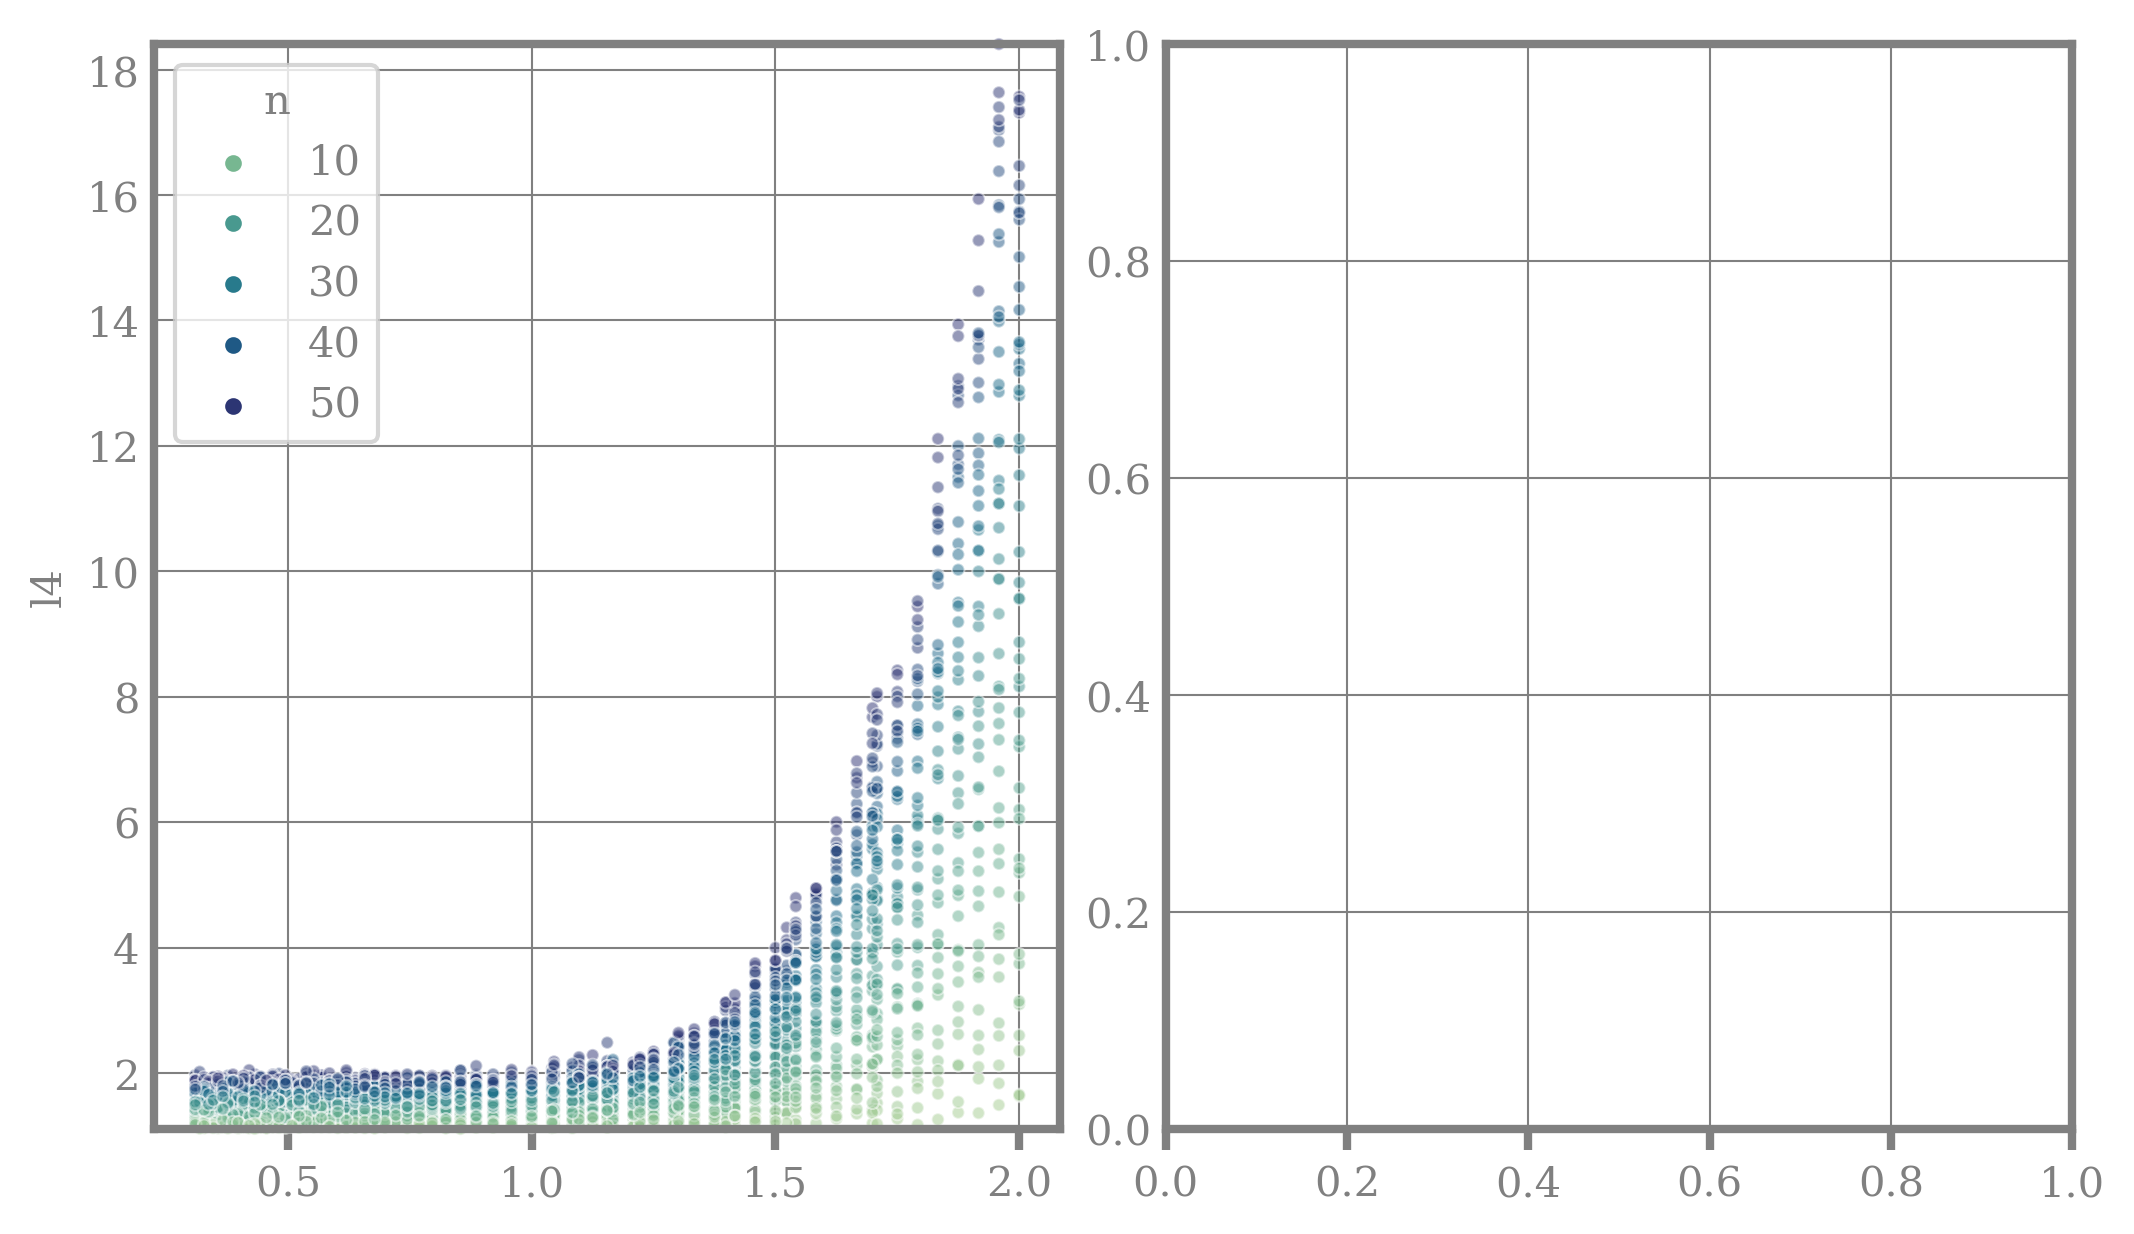

In [52]:
fig,axs = plt.subplots(1,2)
sns.scatterplot(NL_df,x = '-log(m)',y='l_%d'%eigenvalue_index,hue='n',palette = 'crest',ax=axs[0],clip_on=False,alpha=0.5)
axs[0].set_xlabel("m")
axs[0].set_ylabel("l%d"%eigenvalue_index)
axs[0].set_xlabel("")

sns.scatterplot(NL_df,x = '-log(m)',y='p_exp'%eigenvalue_index,hue='n',palette = 'crest',ax=axs[1],clip_on=False,alpha=0.5)
axs[1].set_ylabel("-log10(p%d)"%eigenvalue_index)
axs[1].set_xlabel("")


fig.suptitle("phase transition in -log10(sigma)",y=1.05)
fig.supxlabel("-log10(sigma)")

Text(0.02, 0.5, 'l1')

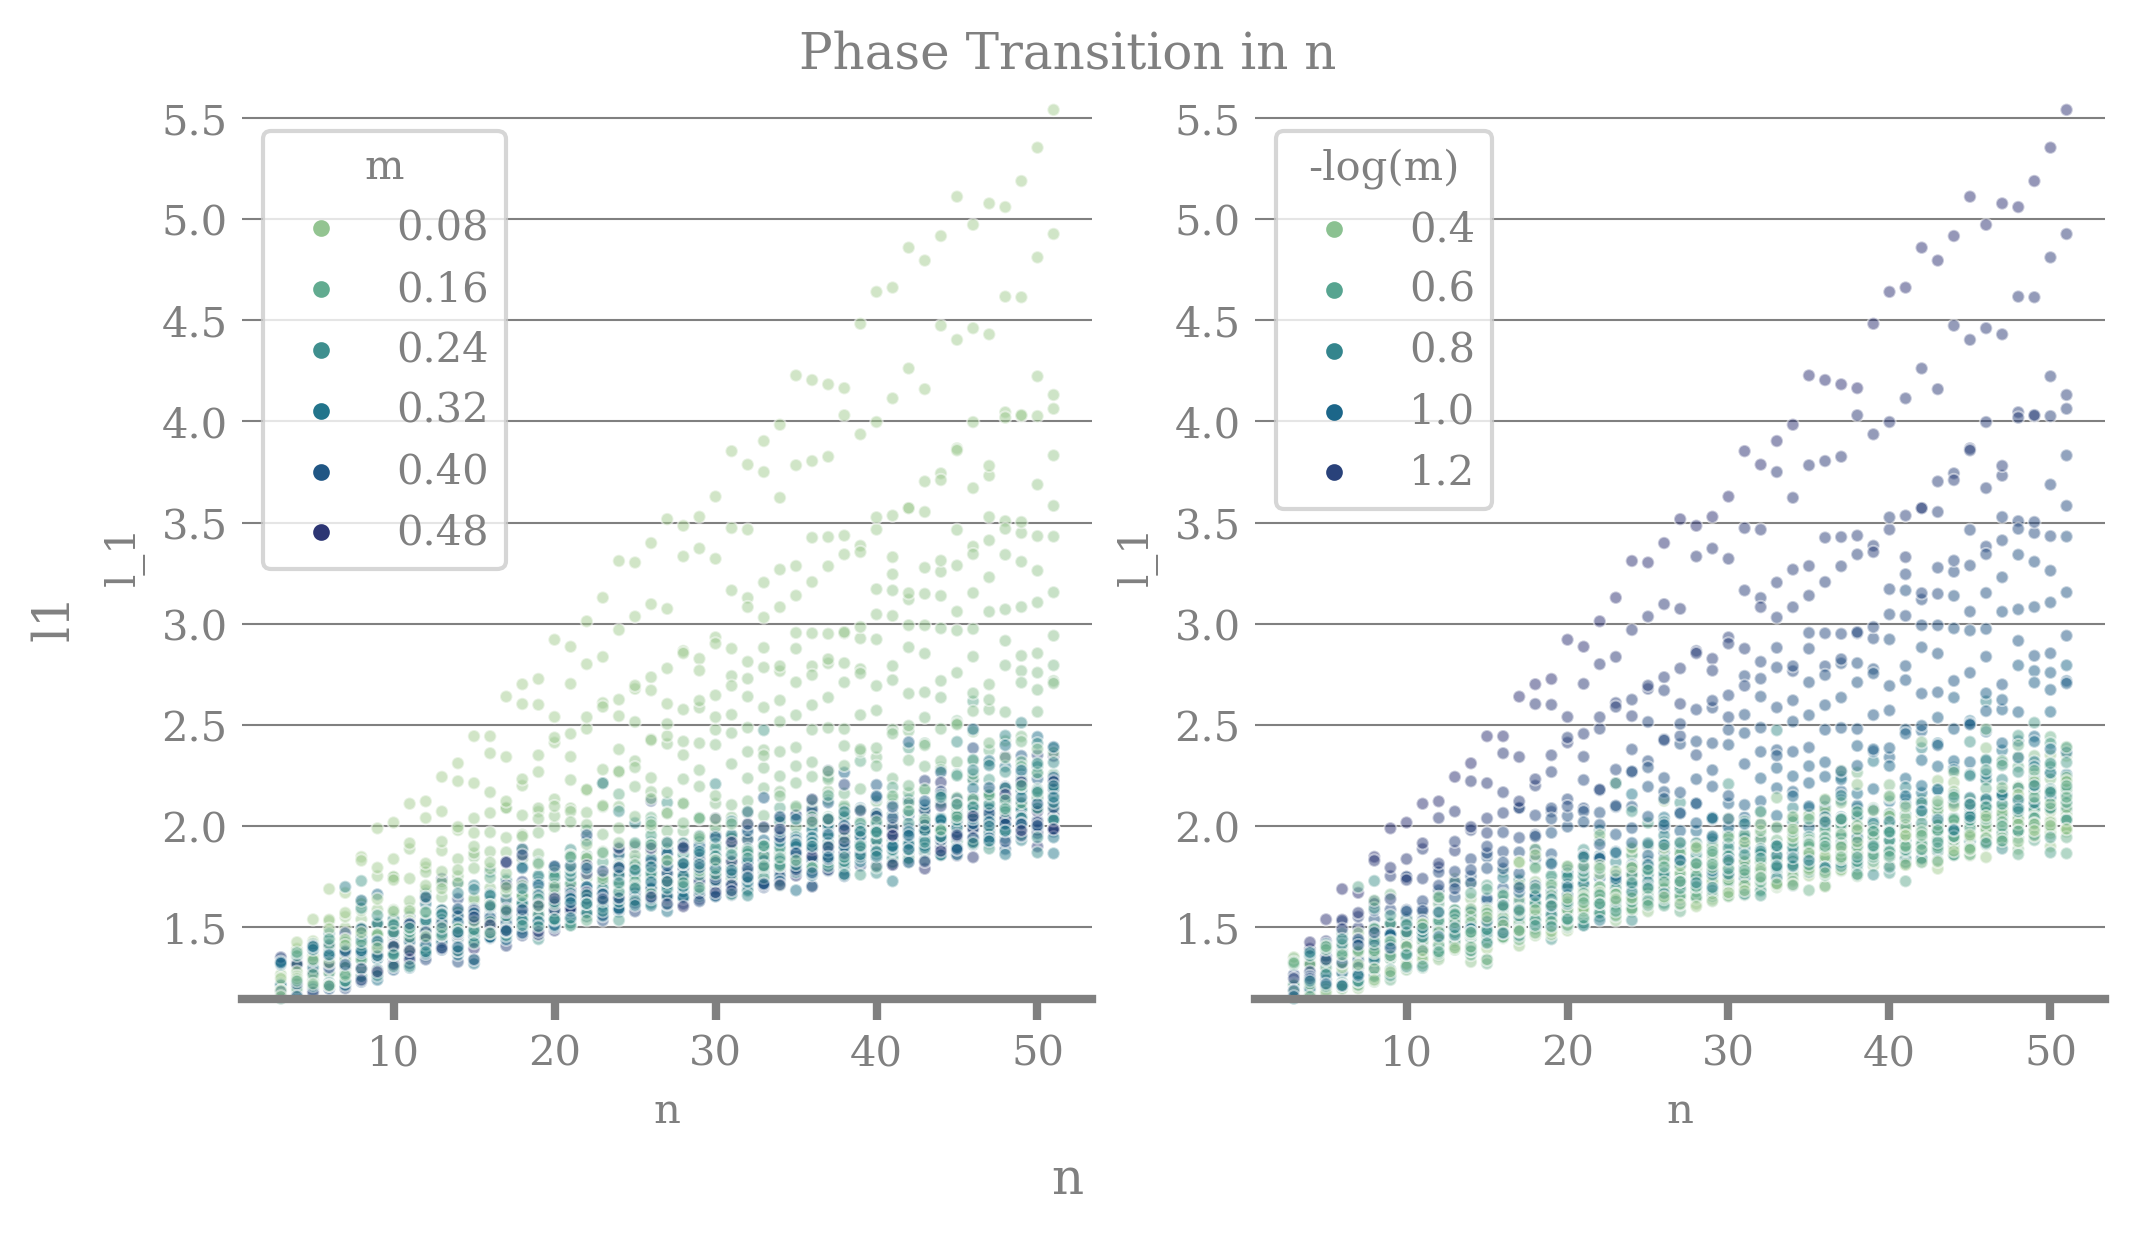

In [ ]:
fig,axs = plt.subplots(1,2)
min_m = 0.05
KLm_df = NL_df[NL_df.m>min_m]
sns.scatterplot(KLm_df,x = 'n',y='l_%d'%eigenvalue_index,hue='m',alpha=0.5,palette = 'crest',ax=axs[0],clip_on=False)
sns.scatterplot(KLm_df,x = 'n',y='p_%d'%eigenvalue_index,hue='-log(m)',alpha=0.5,palette = 'crest',ax=axs[1],clip_on = False)
fig.suptitle("Phase Transition in n")
fig.supxlabel("n")
fig.supylabel("l%d"%eigenvalue_index)


## Point of phase transition

In [10]:
cutoff = 0.88
N=2000
m_threshold_list,n_threshold_list = compute_threshold_array(NL_df,cutoff=cutoff,p=1)

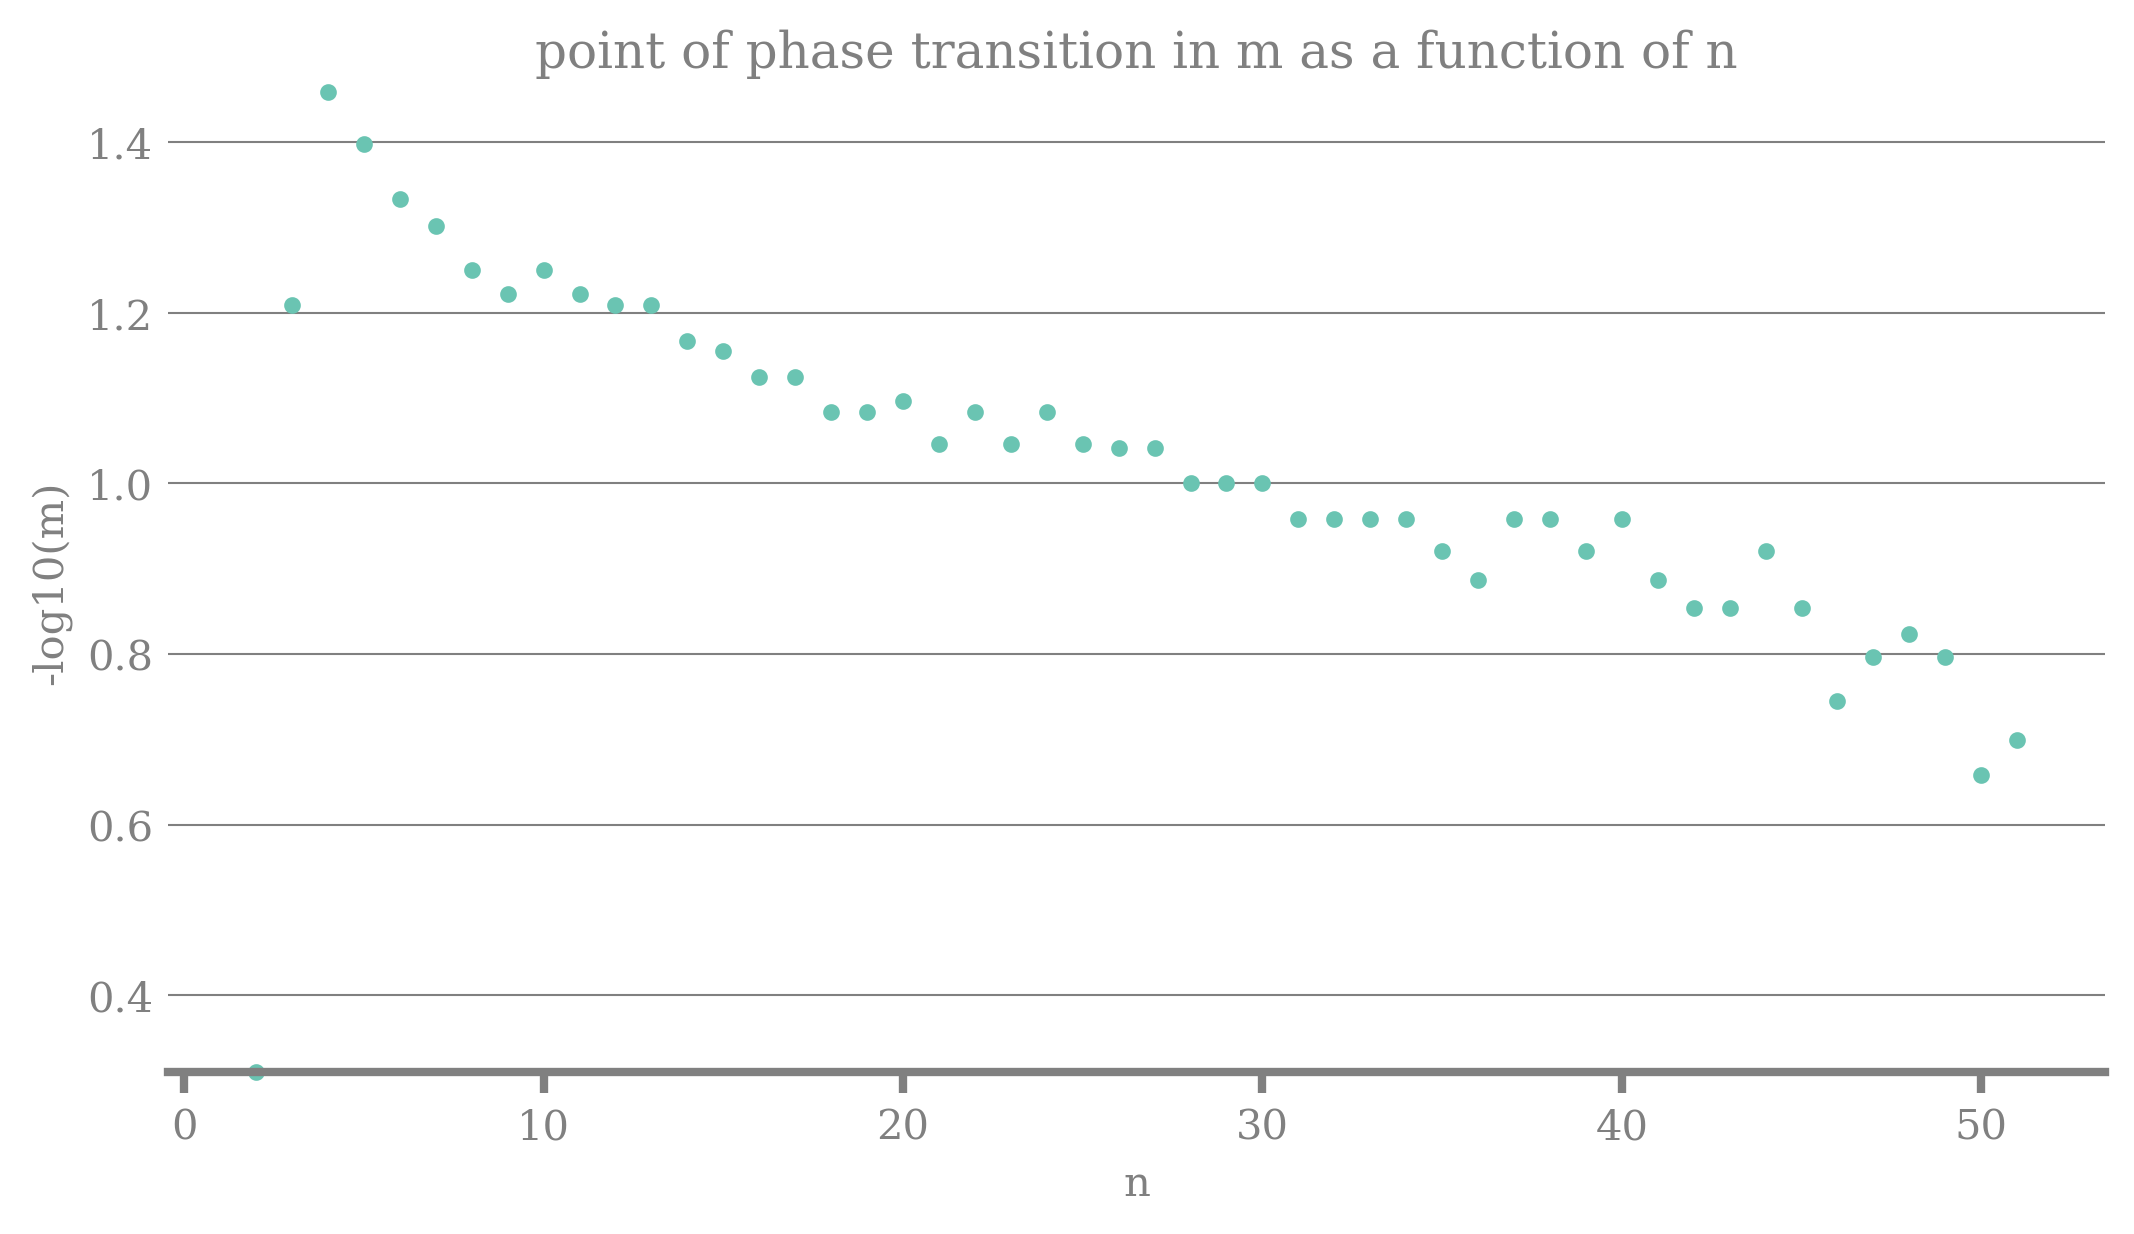

In [11]:
x_values = n_list
y_values = -np.log10(m_threshold_list)
# y_values = m_threshold_list

coefficients = np.polyfit(x_values, y_values, 1)
line_of_best_fit = np.polyval(coefficients, x_values)


plt.scatter(x_values, y_values,label='Data points',clip_on = False)
# plt.plot(x_values, line_of_best_fit, color='red', label='Line of best fit')
plt.xlabel('n')
plt.ylabel('-log10(m)')
# plt.ylabel("m")
plt.title("point of phase transition in m as a function of n")
# plt.legend()
# plt.grid(True)
plt.show()

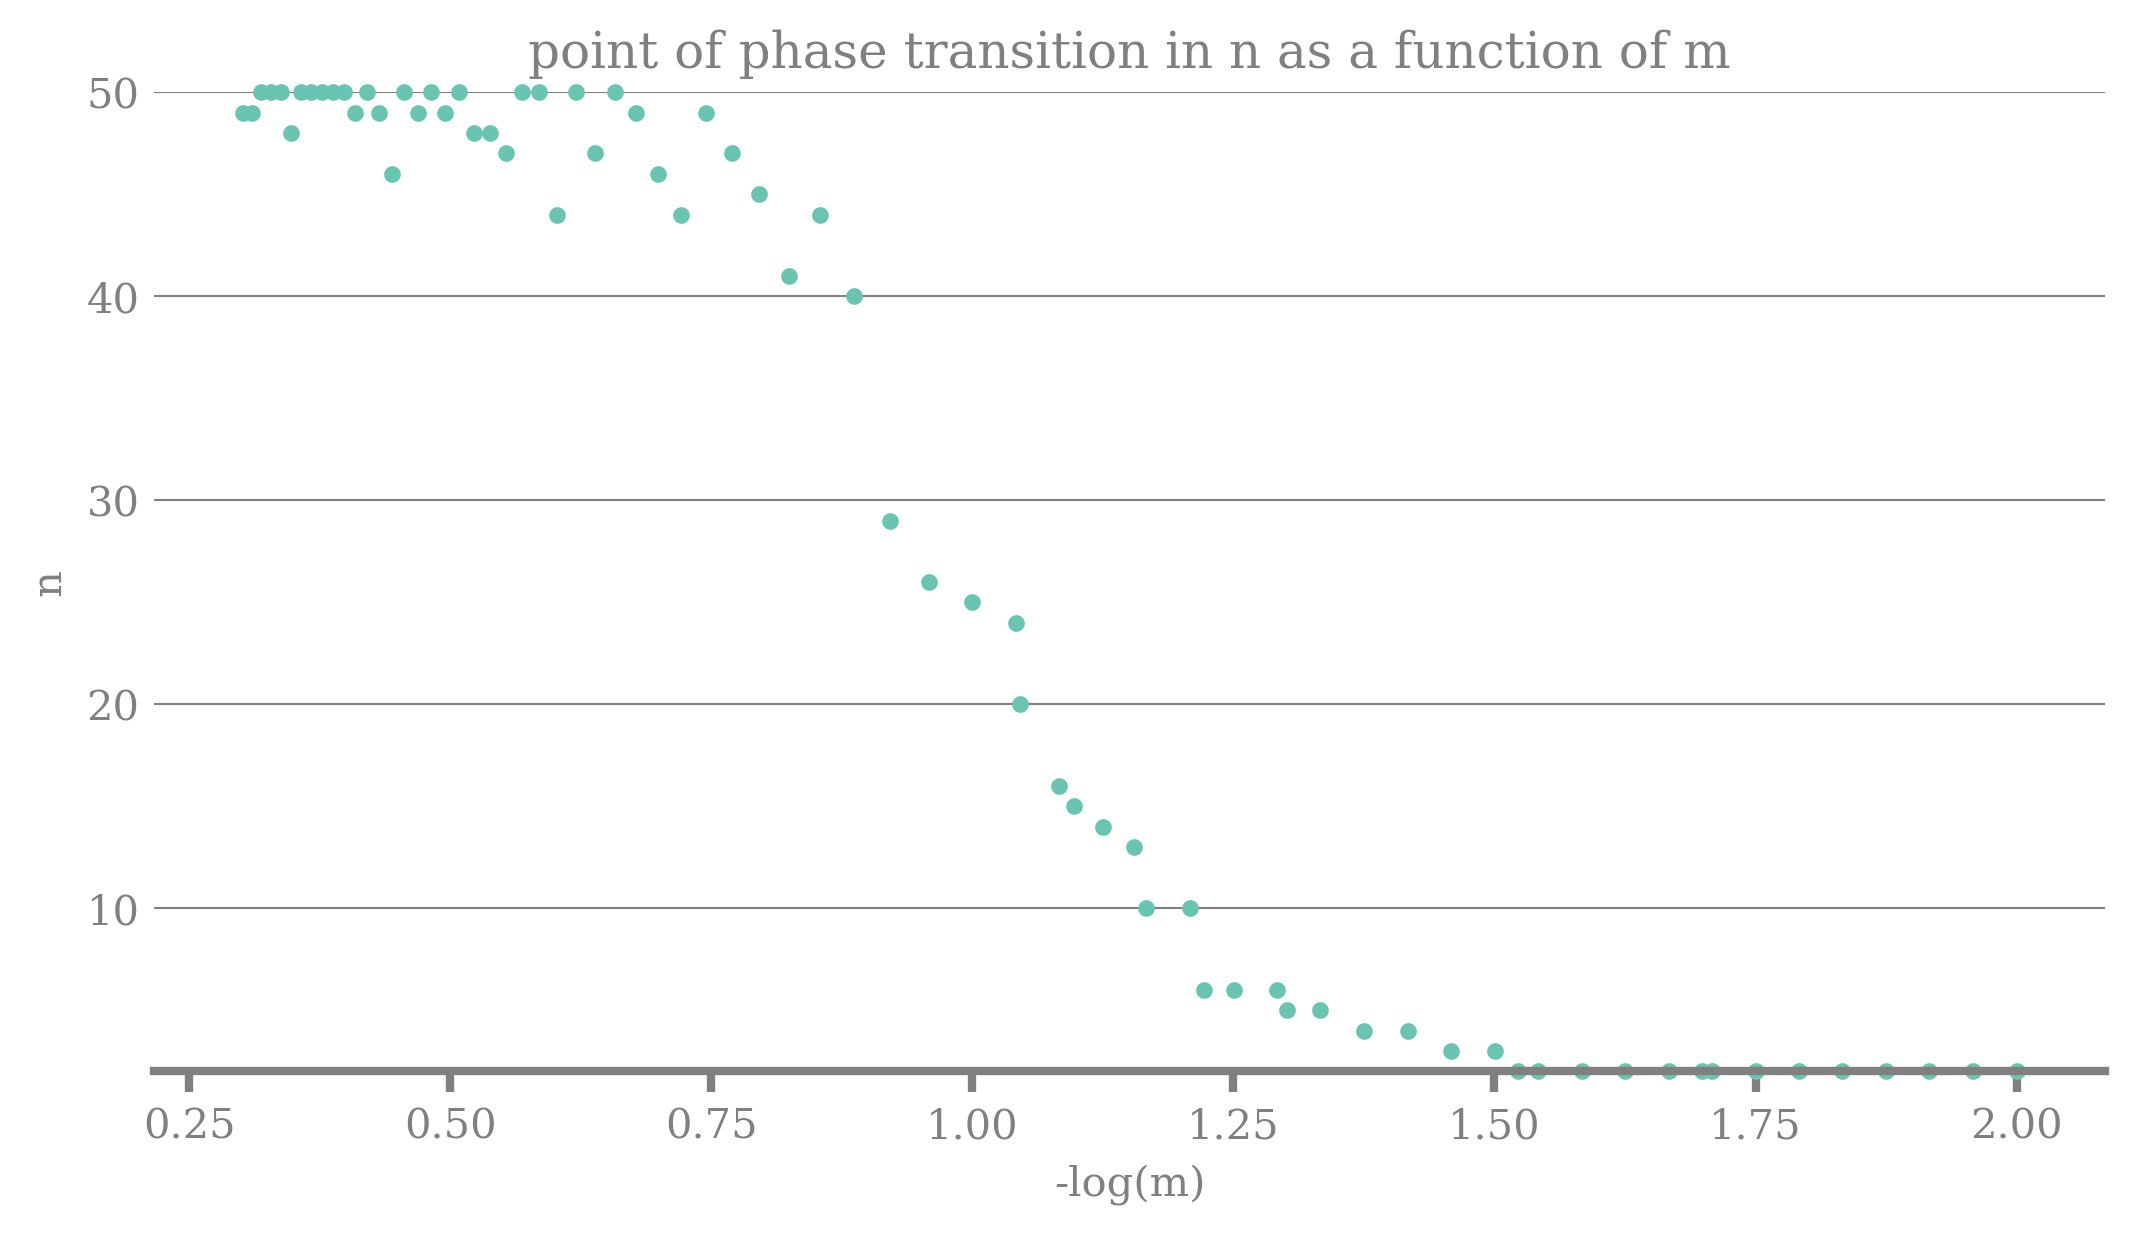

In [12]:
x_values = -np.log10(np.sort(m_list[:-1]))[::-1]
y_values = n_threshold_list

coefficients = np.polyfit(x_values, y_values, 1)
line_of_best_fit = np.polyval(coefficients, x_values)


plt.scatter(x_values, y_values,label='Data points',clip_on=False)
# plt.plot(x_values, line_of_best_fit, color='red', label='Line of best fit')
plt.xlabel('-log(m)')
plt.ylabel('n')
plt.title("point of phase transition in n as a function of m")
# plt.legend()
# plt.grid(True)
plt.show()

## Eigenvectors

In [13]:
def remove_zeros_rows(arr):
    non_zero_indices = (arr != 0)[:,0]
    return arr[non_zero_indices,:]

def extract_PC_map_data(N,n,n_list,L,L_list,m_list,K=3):
    ### Annotate this function

    n_index = np.where(n_list==n)[0][0]
    L_index = np.where(L_list==L)[0][0]
    PCs = np.zeros((int(n*K**2),4,len(m_list)))
    sample_positions_tot = np.zeros((int(n*K**2),2,len(m_list)))
    for m_index,m in enumerate(np.sort(m_list)):
        with open(os.path.join(path,("K=%d,N=%d/m=%.5f")%(K,N,m)).rstrip("0")+"/eigenvectors.pkl","rb") as file:
            eigenvectors = pickle.load(file)
        with open(os.path.join(path,("K=%d,N=%d/m=%.5f")%(K,N,m)).rstrip("0")+"/sample_positions.pkl","rb") as file:
            sample_positions = pickle.load(file)
        sample_positions = remove_zeros_rows(sample_positions[n_index,L_index,:,:])
        n_tot,_ = sample_positions.shape
        sample_positions_tot[:n_tot,:,m_index]= sample_positions

        eigenvectors = eigenvectors[eigenvectors.n==n]
        eigenvectors = eigenvectors[eigenvectors.L==L].iloc[:,2:].values
        eigenvectors = remove_zeros_rows(eigenvectors)

        PCs[:n_tot,:,m_index] = eigenvectors
    return sample_positions_tot,PCs

In [14]:
K=3
N=2000
n= n_list[10]
L=L_list[-2]
sample_positions,PCs = extract_PC_map_data(N,n,n_list,L,L_list,m_list[m_list!=0.5])

In [15]:
## Readding all axis
rcParams['axes.spines.bottom'] = True
rcParams['axes.spines.left'] = True
rcParams['axes.spines.right'] = True
rcParams['axes.spines.top'] = True
## Adding Gridlines in the horizontally
rcParams['axes.grid'] = True
rcParams['axes.grid.axis'] = 'both'
rcParams['grid.color'] = 'grey'
rcParams['grid.linewidth'] = 0.5

Text(0.5, 1.0, 'PC4')

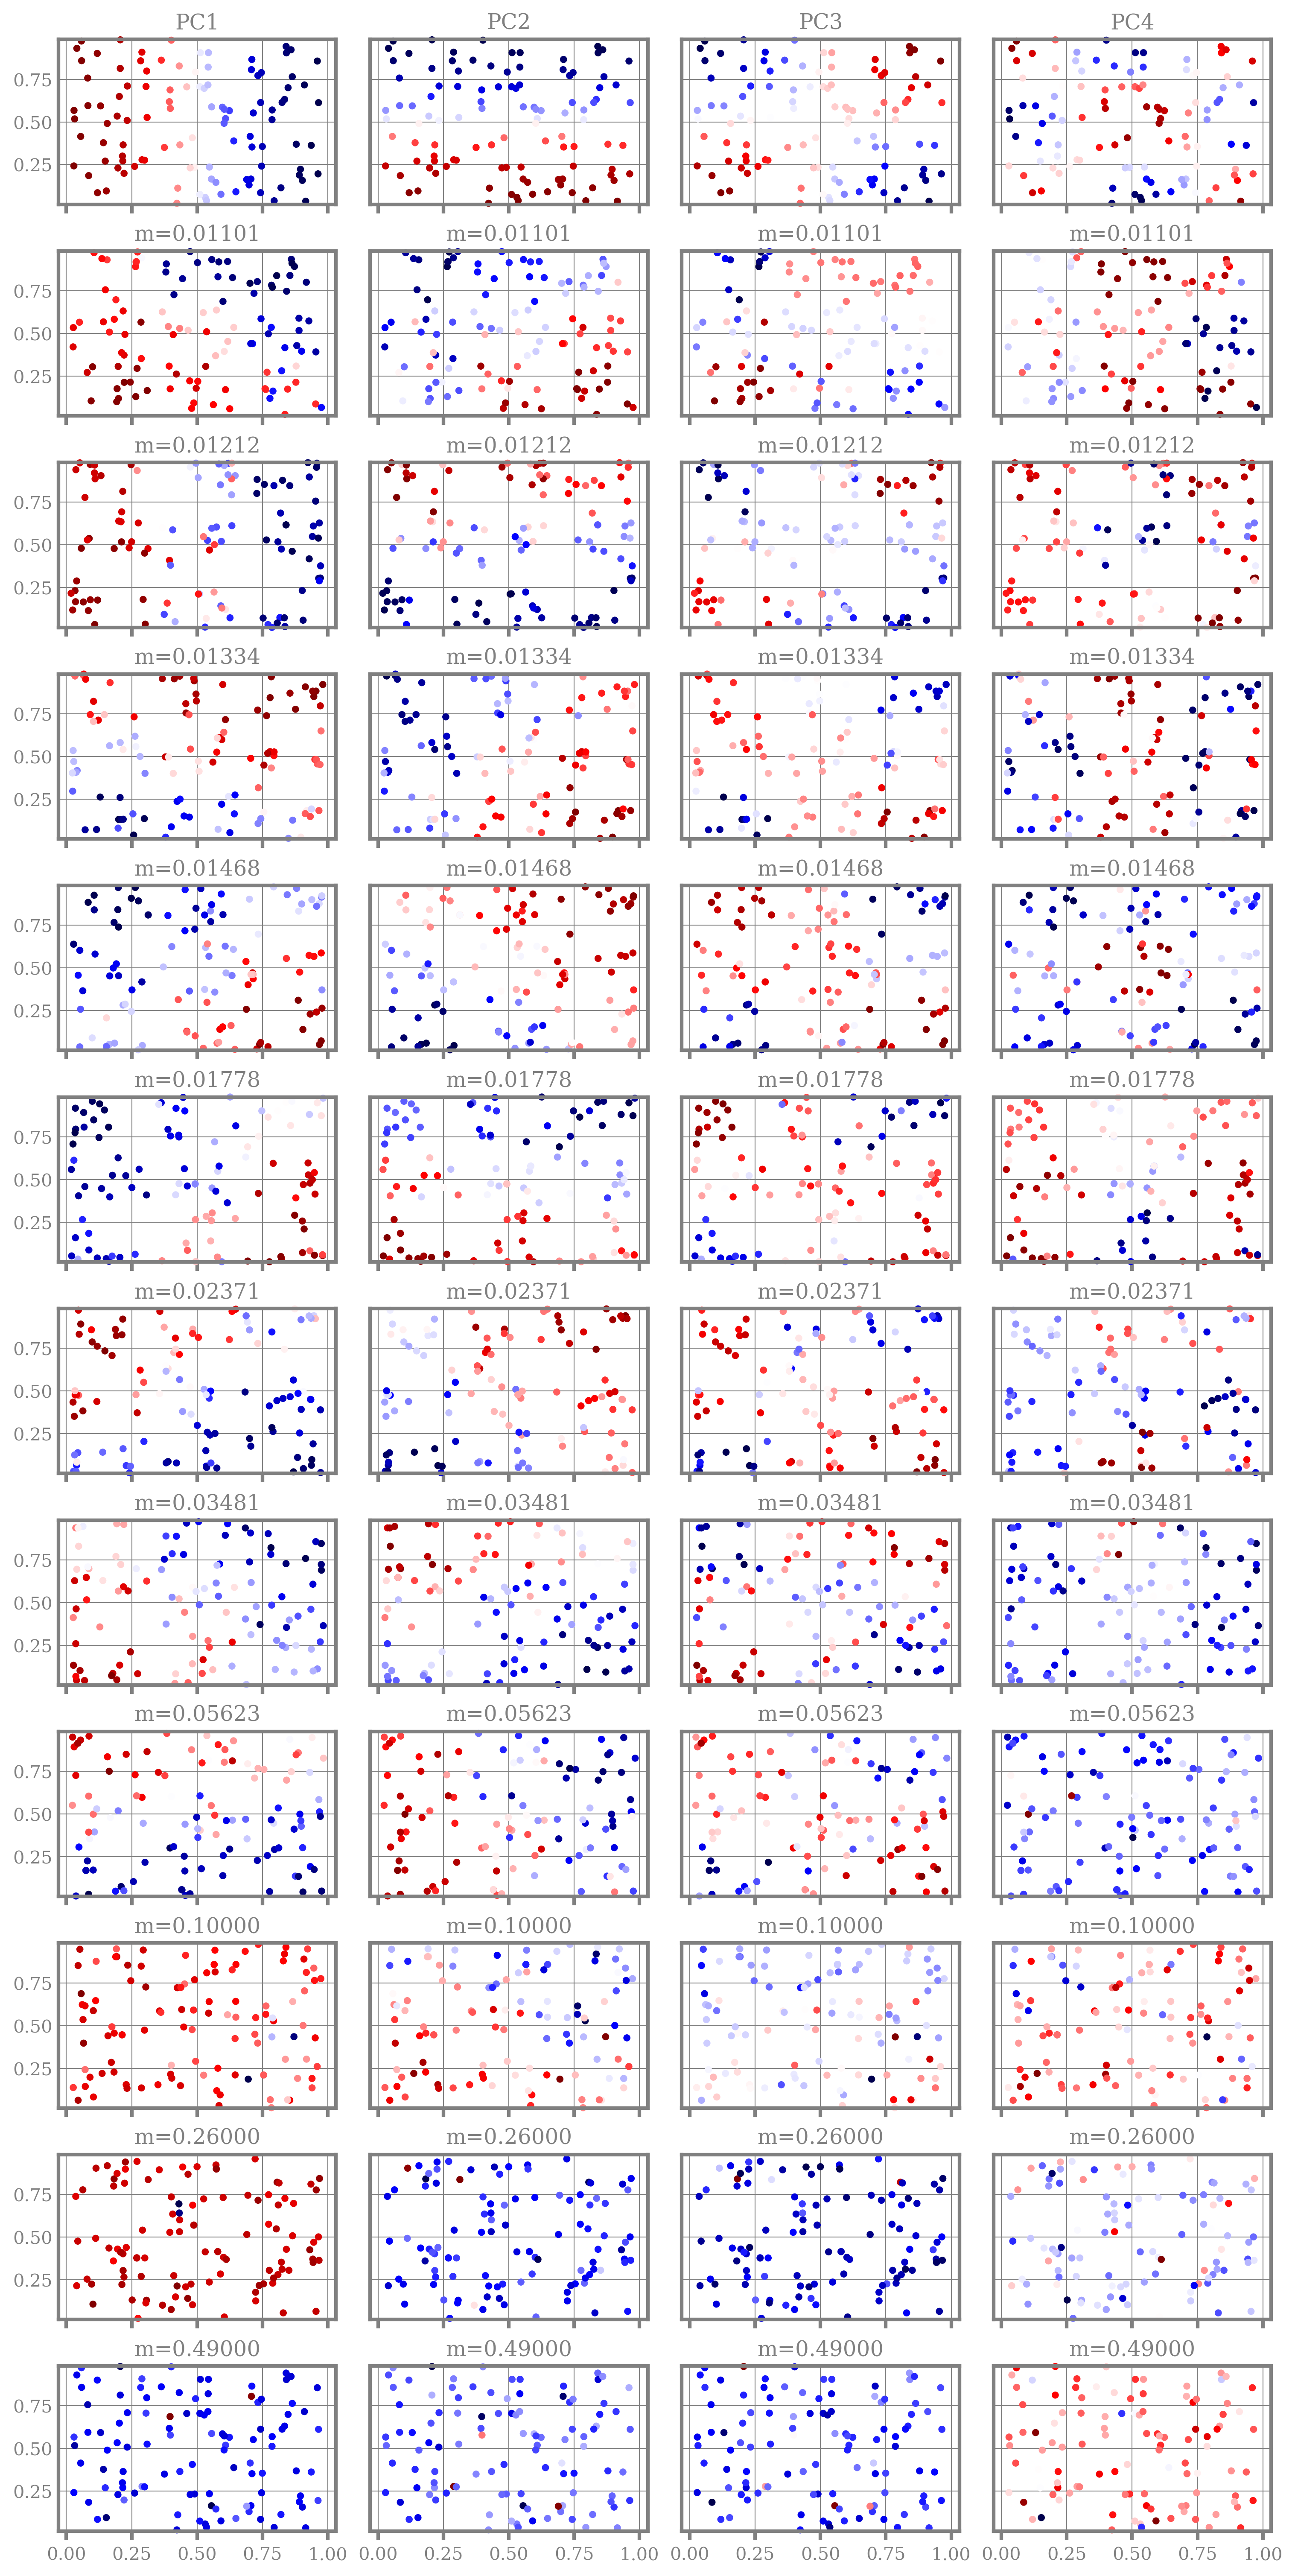

In [42]:
n_tot,_,m_tot = sample_positions.shape
num_m = 12
m_used_inx = np.geomspace(1,m_tot-1,num_m).astype(int)
fig,axs = plt.subplots(num_m,4,figsize = (10,20),sharex = True,sharey=True)
for i in range(1,num_m):
    x = sample_positions_m[:,0]
    y = sample_positions_m[:,1]
    sample_positions_m = sample_positions[:,:,m_used_inx[i]]
    PCs_m = PCs[:,:,m_used_inx[i]]
    for j in range(4):
        axs[i,j].scatter(x,y,c=PCs_m[:,j],clip_on=False)
        axs[i,j].set_title("m=%.5f"%(m_ordered[m_used_inx[i]]))
        
axs[0,0].scatter(x,y,c=np.cos(np.pi*x),clip_on=False)
axs[0,0].set_title("PC1")
axs[0,1].scatter(x,y,c=np.cos(np.pi*y),clip_on=False)
axs[0,1].set_title("PC2")
axs[0,2].scatter(x,y,c=np.cos(np.pi*x)*np.cos(np.pi*y),clip_on=False)
axs[0,2].set_title("PC3")
axs[0,3].scatter(x,y,c=np.cos(2*np.pi*x)*np.cos(2*np.pi*y),clip_on=False)
axs[0,3].set_title("PC4")

